# **Understanding the DMN's Computational Role in Decision-Making**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## **Setting Up**

### Libraries

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.optimize import minimize
from scipy.stats import uniform, pearsonr
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import expit

### Constants

In [3]:
# Figure settings
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# The data is stored in nested directories starting here:
HCP_DIR = "/content/drive/My Drive"

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

### Help functions

#### Processing fMRI data

In [4]:
def get_image_ids(name):
    """Get the 1-based image indices for runs in a given experiment.

    Args:
        name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
        run_ids (list of int) : Numeric ID for experiment image files

    """
    run_ids = [
                i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
              ]
    if not run_ids:
        raise ValueError(f"Found no data for '{name}'")
    return run_ids

def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

    Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(os.path.join(bold_path, bold_file))
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
    """Load timeseries data for a single subject.

    Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

    Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

    """
    # Get the list relative 0-based index of runs to use
    if runs is None:
        runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
    elif isinstance(runs, int):
        runs = [runs]

    # Get the first (1-based) run id for this experiment
    offset = get_image_ids(name)[0]

    # Load each run's data
    bold_data = [
                    load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
                ]

    # Optionally concatenate in time
    if concat:
        bold_data = np.concatenate(bold_data, axis=-1)

    return bold_data


def load_evs(subject, name, condition, dir):
    """Load EV (explanatory variable) data for one task condition.

    Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

    Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.

    """
    evs = []
    for id in get_image_ids(name):
        task_key = BOLD_NAMES[id - 1]
        ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                            task_key, f"{condition}.txt")
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
        evs.append(ev)
    return evs

def average_dmn_signal(dmn_signal, onsets, feedback_delay, feedback_duration, tr):
    """
    Calculate the average DMN signal before the feedback period starts for each event.

    Args:
    - dmn_signal (ndarray): The DMN time series for a given trial (shape: n_parcels x n_timepoints)
    - onsets (list): List of event onsets in seconds
    - feedback_delay (float): Time in seconds before feedback starts after the event onset
    - feedback_duration (float): Duration of feedback in seconds
    - tr (float): The time resolution (TR) in seconds

    Returns:
    - avg_dmn_signals (list): List of average DMN signals for each trial before feedback
    """
    avg_dmn_signals = []
    for onset in onsets:
        # Calculate the time window before feedback starts (from onset to onset + feedback_delay)
        pre_feedback_start = onset
        pre_feedback_end = onset + feedback_delay

        # Convert the time window from seconds to timepoints (index)
        start_idx = int(np.round(pre_feedback_start / tr))
        end_idx = int(np.round(pre_feedback_end / tr))

        # Get the DMN signal in this window for all parcels
        dmn_window = dmn_signal[:, start_idx:end_idx]

        # Calculate the average signal across DMN parcels for this window
        avg_dmn_signal = np.mean(dmn_window, axis=0)
        avg_dmn_signals.append(np.mean(avg_dmn_signal))  # Mean across timepoints in the window

    return avg_dmn_signals

#### Loading reaction times, choices and feedback

In [10]:
def load_reaction_times(subject, run):
    # Path to the reaction times file
    file_path = f"/content/drive/My Drive/ReactionTimes/{subject}/{run}.csv"

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Replace 0 (no response) with 9999 in the "Reaction Time" column
    df["Reaction Time"] = df["Reaction Time"].replace(0, 9999)

    # Return the reaction times as a NumPy array
    reaction_times = df["Reaction Time"].to_numpy()
    return reaction_times


# Load choices and the given feedbacks for a specific subject and run
def load_choice_feedback(subject, run):
    choices_file = f"/content/drive/My Drive/Choices/{subject}/{run}.csv"

    df = pd.read_csv(choices_file, engine="python")

    # Map TrialType to numerical feedback for RL modeling
    feedback_map = {"Reward": 1, "Punishment": 0, "Neutral": 0.5}
    df["Feedback"] = df["TrialType"].map(feedback_map)

    # Map SubjectChoice to numerical encoding for modeling
    choice_map = {"Higher than five": 1, "Lower than five": 0, "No Choice": -1}
    df["Choice"] = df["SubjectChoice"].map(choice_map)

    choices = df["Choice"].to_numpy()
    feedbacks = df["Feedback"].to_numpy()

    return choices, feedbacks

#### Reinforcement learning model

In [13]:
def sim_subject_ewa(alpha, beta, phi, feedback):
    n = len(feedback)
    Q = np.array([0.5, 0.5])  # Initialize Q-values
    experience_weights = np.array([0.5, 0.5])  # Initial experience weights for actions
    actions = []
    rewards = []
    Qs = []

    for t in range(n):
        if t > 0:  # Update experience weights only after the first trial
            # Update experience weights for the actions
            experience_weights[0] = (1 - phi) * experience_weights[0] + phi * (1 if actions[-1] == 0 else 0)
            experience_weights[1] = (1 - phi) * experience_weights[1] + phi * (1 if actions[-1] == 1 else 0)

        # Softmax decision rule (simulating action choice)
        exp_Q = np.exp(beta * Q)
        probs = exp_Q / np.sum(exp_Q)  # Action probabilities based on Q-values
        a = np.random.choice([0, 1], p=probs)  # Simulate choice

        r = feedback[t]  # Actual feedback

        # Update Q-values based on feedback
        Q[a] += alpha * (r - Q[a])

        # Store results
        actions.append(a)
        rewards.append(r)
        Qs.append(Q.copy())

    return np.array(actions), np.array(rewards), np.array(Qs)

# Experience-weighted attraction (EWA) model
def ewa_model(params, choices, feedback):
    alpha, beta, phi = params  # Extract alpha, beta, phi
    n = len(feedback)
    Q = np.ones(2) * 0.5  # Initialize Q-values
    predicted_choices = []
    experience_weights = np.ones(2)  # Initial experience weights for actions

    for t in range(n):
        # Update Q-values with EWA model
        Q[0] = (1 - alpha) * Q[0] + alpha * feedback[t]  # Action 0 value
        Q[1] = (1 - alpha) * Q[1] + alpha * feedback[t]  # Action 1 value

        # Update experience weights
        experience_weights[0] = (1 - phi) * experience_weights[0] + phi * (1 if choices[t] == 0 else 0)
        experience_weights[1] = (1 - phi) * experience_weights[1] + phi * (1 if choices[t] == 1 else 0)

        # Softmax decision rule
        exp_Q = np.exp(beta * Q)
        probs = exp_Q / np.sum(exp_Q)
        predicted_choice = np.random.choice([0, 1], p=probs)
        # predicted_choice = np.argmax(probs)
        predicted_choices.append(predicted_choice)

    # Calculate the error between actual and predicted choices
    choice_error = np.sum(np.abs(np.array(predicted_choices) - choices))  # Absolute error
    return choice_error  # Minimize this error

# Optimization function
def optimize_ewa(choices, feedback):
    best_error, best_params = float("inf"), None

    for _ in range(100):
        x0 = [np.random.uniform(0.01, 1), np.random.uniform(0.1, 10), np.random.uniform(0, 1)]  # Random initial values for alpha, beta, phi
        bounds = [(1e-6, 1 - 1e-6), (0.1, 10), (0, 1)]  # Bounds for parameters

        # Optimize using L-BFGS-B
        result = minimize(
            ewa_model, x0, args=(choices, feedback),
            method="L-BFGS-B", bounds=bounds
        )
        print(f"Params: {result.x}, Error: {result.fun}")
        if result.success and result.fun < best_error:
            best_error = result.fun
            best_params = result.x  # Return best parameters (alpha, beta, phi)
    return best_params

#### Logistic regession model

In [8]:
def prepare_history_features(choices, feedbacks, Mr, Mc):
    """
    Prepare the history feature matrix for the model.

    Args:
    - choices: Array of past choices (1 or -1).
    - feedbacks: Array of past rewards (-1, 0, or 1).
    - Mr: Number of reward history trials to consider.
    - Mc: Number of choice history trials to consider.

    Returns:
    - X: Feature matrix (n_trials, Mr + Mc).
    - y: Target variable (choices at current trial, 0 or 1).
    """
    n_trials = len(choices)
    X = []
    y = []

    for t in range(max(Mr, Mc), n_trials):
        # Reward features (separate for each reward history)
        r_features = [feedbacks[t - m] for m in range(1, Mr + 1)]

        # Choice history features (handle 'No Choice' as NaN or neutral)
        c_features = [choices[t - m] if choices[t - m] != -1 else np.nan for m in range(1, Mc + 1)]

        # Combine features (separate reward and choice terms)
        X.append(r_features + c_features)

        # Current choice as binary target (1 for higher, 0 for lower)
        y.append(1 if choices[t] == 1 else 0)

    return np.array(X), np.array(y)
def initialize_coefficients(n_features):
    """
    Initialize the model coefficients to zero.

    Args:
    - n_features: Number of features.

    Returns:
    - coefficients: Initialized coefficients (array of zeros).
    """
    return np.zeros(n_features)

def predict(coefficients, X):
    """
    Compute the probability for each sample in X.

    Args:
    - coefficients: Model coefficients.
    - X: Feature matrix (n_samples, n_features).

    Returns:
    - probabilities: Predicted probabilities (n_samples,).
    """
    linear_combination = np.dot(X, coefficients)
    return expit(linear_combination)  # Apply sigmoid to get probabilities

def compute_gradient(X, y, predictions):
    """
    Compute the gradient of the binary cross-entropy loss.

    Args:
    - X: Feature matrix (n_samples, n_features).
    - y: Target variable (n_samples,).
    - predictions: Predicted probabilities (n_samples,).

    Returns:
    - gradient: Gradient of the loss function (n_features,).
    """
    n_samples = X.shape[0]
    return np.dot(X.T, predictions - y) / n_samples

def update_coefficients(coefficients, gradient, lr):
    """
    Update the model coefficients using the gradient.

    Args:
    - coefficients: Current model coefficients.
    - gradient: Computed gradient.
    - lr: Learning rate.

    Returns:
    - updated_coefficients: Updated coefficients.
    """
    return coefficients - lr * gradient

def compute_loss(y, predictions):
    """
    Compute the binary cross-entropy loss.

    Args:
    - y: Target variable (n_samples,).
    - predictions: Predicted probabilities (n_samples,).

    Returns:
    - loss: Computed loss value.
    """
    return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

def fit_model(X, y, Mr, Mc, lr=0.001, epochs=1000):
    """
    Train the model using gradient descent and categorize coefficients.

    Args:
    - X: Feature matrix (n_samples, n_features).
    - y: Target variable (n_samples,).
    - lr: Learning rate.
    - epochs: Number of iterations.
    - Mr: Number of history terms for rewards.
    - Mc: Number of history terms for choices.

    Returns:
    - coefficients: Trained model coefficients.
    """
    n_samples, n_features = X.shape
    coefficients = initialize_coefficients(n_features)

    for epoch in range(epochs):
        # Calculate predictions
        predictions = predict(coefficients, X)

        # Compute gradient of binary cross-entropy loss
        gradient = compute_gradient(X, y, predictions)

        # Update coefficients
        coefficients = update_coefficients(coefficients, gradient, lr)

        # Optionally print loss for monitoring
        if epoch % 100 == 0:
            loss = compute_loss(y, predictions)
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    # Categorize coefficients
    reward_coefficients = coefficients[:Mr]
    choice_coefficients = coefficients[Mr:Mr + Mc]

    # Label coefficients with corresponding trial history
    print("\nFinal Coefficients:")
    print("Reward Coefficients:")
    for i, coef in enumerate(reward_coefficients):
        print(f"  Coefficient for reward {Mr - i} trial(s) ago: {coef:.4f}")

    print("\nChoice Coefficients:")
    for i, coef in enumerate(choice_coefficients):
        print(f"  Coefficient for choice {Mc - i} trial(s) ago: {coef:.4f}")

    return coefficients

def sim_subject_lr(coefficients, choices, feedbacks, Mr, Mc):
    """
    Simulate choices based on trained coefficients.
    Args:
    - coefficients: Trained model coefficients (array of weights).
    - choices: Original choice history.
    - feedbacks: Original feedback history.
    - Mr, Mc: History lengths for rewards and choices.
    Returns:
    - simulated_choices: Simulated choice sequence.
    """
    n_trials = len(choices)
    simulated_choices = [np.nan] * max(Mr, Mc)  # Pad initial trials

    for t in range(max(Mr, Mc), n_trials):
        # Prepare features for trial t
        r_features = [feedbacks[t - m] for m in range(1, Mr + 1)]
        c_features = [choices[t - m] for m in range(1, Mc + 1)]
        X_current = np.array(r_features + c_features).reshape(1, -1)

        # Compute the linear combination of features and coefficients
        linear_combination = np.dot(X_current, coefficients)

        # Apply the logistic sigmoid function
        prob = 1 / (1 + np.exp(-linear_combination))

        # Simulate choice
        simulated_choice = 1 if np.random.rand() < prob else 0
        simulated_choices.append(simulated_choice)

    return np.array(simulated_choices)

#### Analysis

In [14]:
def average_dmn(subject, run, feedback): # Avergare pre-feedback period DMN activity
    if run == "RL":
        run_as_num = 0
    elif run == "LR":
        run_as_num = 1

    timeseries_task = []
    timeseries_task.append(load_timeseries(subject, task, dir=os.path.join(HCP_DIR, "hcp_task"), concat=False))
    run_timeseries_task = timeseries_task[0][run_as_num]
    dmn_signal = run_timeseries_task[DMN_PARCELS, :]

    win_evs = load_evs(subject, task, "win_event", dir=os.path.join(HCP_DIR, "hcp_task"))
    loss_evs = load_evs(subject, task, "loss_event", dir=os.path.join(HCP_DIR, "hcp_task"))
    neut_evs = load_evs(subject, task, "neut_event", dir=os.path.join(HCP_DIR, "hcp_task"))

    win_onsets = win_evs[run_as_num]["onset"]
    loss_onsets = loss_evs[run_as_num]["onset"]
    neut_onsets = neut_evs[run_as_num]["onset"]

    # Calculate the average DMN signal during pre-feedback period for each trial type
    win_avg_dmn = average_dmn_signal(dmn_signal, win_onsets, 1.5, 1.0, TR)
    loss_avg_dmn = average_dmn_signal(dmn_signal, loss_onsets, 1.5, 1.0, TR)
    neut_avg_dmn = average_dmn_signal(dmn_signal, neut_onsets, 1.5, 1.0, TR)

    win_idx, loss_idx, neut_idx = 0, 0, 0

    avg_dmn = []

    # Loop through each trial outcome
    for i, outcome in enumerate(feedback):
        if outcome == 1 and win_idx < len(win_avg_dmn):
            avg_dmn.append(win_avg_dmn[win_idx])
            win_idx += 1
        elif outcome == 0 and loss_idx < len(loss_avg_dmn):
            avg_dmn.append(loss_avg_dmn[loss_idx])
            loss_idx += 1
        elif outcome == 0.5 and neut_idx < len(neut_avg_dmn):
            avg_dmn.append(neut_avg_dmn[neut_idx])
            neut_idx += 1
        else:
            avg_dmn.append(None)  # Handle cases where DMN signal isn't available for a trial

    return avg_dmn

def trial_by_trial_regression(dmn_signals, feedbacks, choices, Mr, Mc):

    n_trials = len(dmn_signals)
    reward_predictors = []
    choice_predictors = []

    for t in range(n_trials):
        r_features = feedbacks[max(0, t - Mr):t][::-1]  # Past rewards
        c_features = choices[max(0, t - Mc):t][::-1]    # Past choices

        # Pad with zeros if not enough history
        r_features = np.pad(r_features, (Mr - len(r_features), 0), mode="constant")
        c_features = np.pad(c_features, (Mc - len(c_features), 0), mode="constant")

        reward_predictors.append(r_features)
        choice_predictors.append(c_features)

    reward_predictors = np.array(reward_predictors)
    choice_predictors = np.array(choice_predictors)

    # Regress DMN signals on reward predictors
    reward_model = LinearRegression()
    reward_model.fit(reward_predictors, dmn_signals)
    predicted_reward_dmn = reward_model.predict(reward_predictors)

    # Regress DMN signals on choice predictors
    choice_model = LinearRegression()
    choice_model.fit(choice_predictors, dmn_signals)
    predicted_choice_dmn = choice_model.predict(choice_predictors)

    # Correlate predicted signals with actual DMN signals
    reward_corr = pearsonr(predicted_reward_dmn, dmn_signals)
    choice_corr = pearsonr(predicted_choice_dmn, dmn_signals)

    return {
        "RewardCorrelation": reward_corr,
        "ChoiceCorrelation": choice_corr
    }

### Loading region information
`regions.npy` file contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).
We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [6]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

with np.load(HCP_DIR + f"/atlas.npz") as dobj:
    atlas = dict(**dobj)

In [7]:
# Indices of parcels corresponding to the DMN (labeled as "Default")
DMN_PARCELS = [i for i, network in enumerate(region_info["network"]) if network == "Default"]

## **Task description**

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## **Extracting Info**

### Choices

In [ ]:
for subject in range(1, N_SUBJECTS):
    for run in ["RL", "LR"]:
        folder_path = f"/content/drive/My Drive/hcp_task/subjects/{subject}/EVs/tfMRI_GAMBLING_{run}/"

        # Find the file matching the pattern
        file_pattern = os.path.join(folder_path, "GAMBLING_run*_TAB.txt")
        matching_files = glob.glob(file_pattern)

        if matching_files:
            tsv_file = matching_files[0]  # Since there's only one file with this pattern, take the first one

            df = pd.read_csv(tsv_file, delimiter='\t')

            trial_info = df[["ConsecSmallerGuesses", "ConsecLargerGuesses", "FeedbackNumber", "TrialType", "QuestionMark.RT"]]
            trial_info = trial_info.dropna(subset=["TrialType"]).reset_index(drop=True)
            trial_info.loc[:, "TrialNumber"] = range(1, len(trial_info) + 1)

            # Determine the subject's choice based on the columns
            trial_info.loc[:, "SubjectChoice"] = trial_info.apply(
                lambda row: "No Choice" if row["QuestionMark.RT"] == 0 else
                            ("Higher than five" if row["ConsecSmallerGuesses"] == 0 else
                             ("Lower than five" if row["ConsecLargerGuesses"] == 0 else "Undetermined")), axis=1)

            trial_info = trial_info[["TrialNumber", "SubjectChoice", "TrialType"]]

            output_dir = f"./Choices/{subject}/"
            output_path = os.path.join(output_dir, f"{run}.csv")
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            trial_info.to_csv(output_path, index=False)

        else:
            print(f"No file found for subject {subject}, run {run}")

### Reaction Times

In [ ]:
for subject in range(1, N_SUBJECTS):
    for run in ["RL", "LR"]:
        folder_path = f"/content/drive/My Drive/hcp_task/subjects/{subject}/EVs/tfMRI_GAMBLING_{run}/"

        # Find the file matching the pattern
        file_pattern = os.path.join(folder_path, "GAMBLING_run*_TAB.txt")
        matching_files = glob.glob(file_pattern)

        if matching_files:
            tsv_file = matching_files[0]  # Since there's only one file with this pattern, take the first one

            df = pd.read_csv(tsv_file, delimiter='\t')

            # Exclude rows where "TrialType" is NaN
            filtered_df = df.dropna(subset=["TrialType"])

            # Extract the reaction time column and create a copy
            rt_info = filtered_df[["QuestionMark.RT"]].copy()
            rt_info.rename(columns={"QuestionMark.RT": "Reaction Time"}, inplace=True)

            rt_info["TrialNumber"] = range(1, len(rt_info) + 1)

            output_dir = f"./ReactionTimes/{subject}/"
            output_path = os.path.join(output_dir, f"{run}.csv")
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            rt_info.to_csv(output_path, index=False)

        else:
            print(f"No file found for Subject {subject}, Run {run}")


### Reinforcement learning parameters

In [ ]:
# Store results for RL and LR
results_rl = []
results_lr = []

# Loop through subjects and runs
for subject in range(1, N_SUBJECTS):
    for run in ["RL", "LR"]:
        try:
            choices, feedback = load_choice_feedback(subject, run)
            params = optimize_ewa(choices, feedback)
            alpha, beta, phi = params

            if run == "RL":
                results_rl.append({"Subject": subject, "Alpha": alpha, "Beta": beta, "Phi": phi})
            elif run == "LR":
                results_lr.append({"Subject": subject, "Alpha": alpha, "Beta": beta, "Phi": phi})
        except Exception as e:
            print(f"Error processing Subject {subject}, Run {run}: {e}")

# Convert results to DataFrames and save
results_rl_df = pd.DataFrame(results_rl)
results_lr_df = pd.DataFrame(results_lr)

results_rl_df.to_csv("./RL.csv", index=False)
results_lr_df.to_csv("./LR.csv", index=False)

## **Visualization**

### Aganet choices vs Actual choices (EWA)

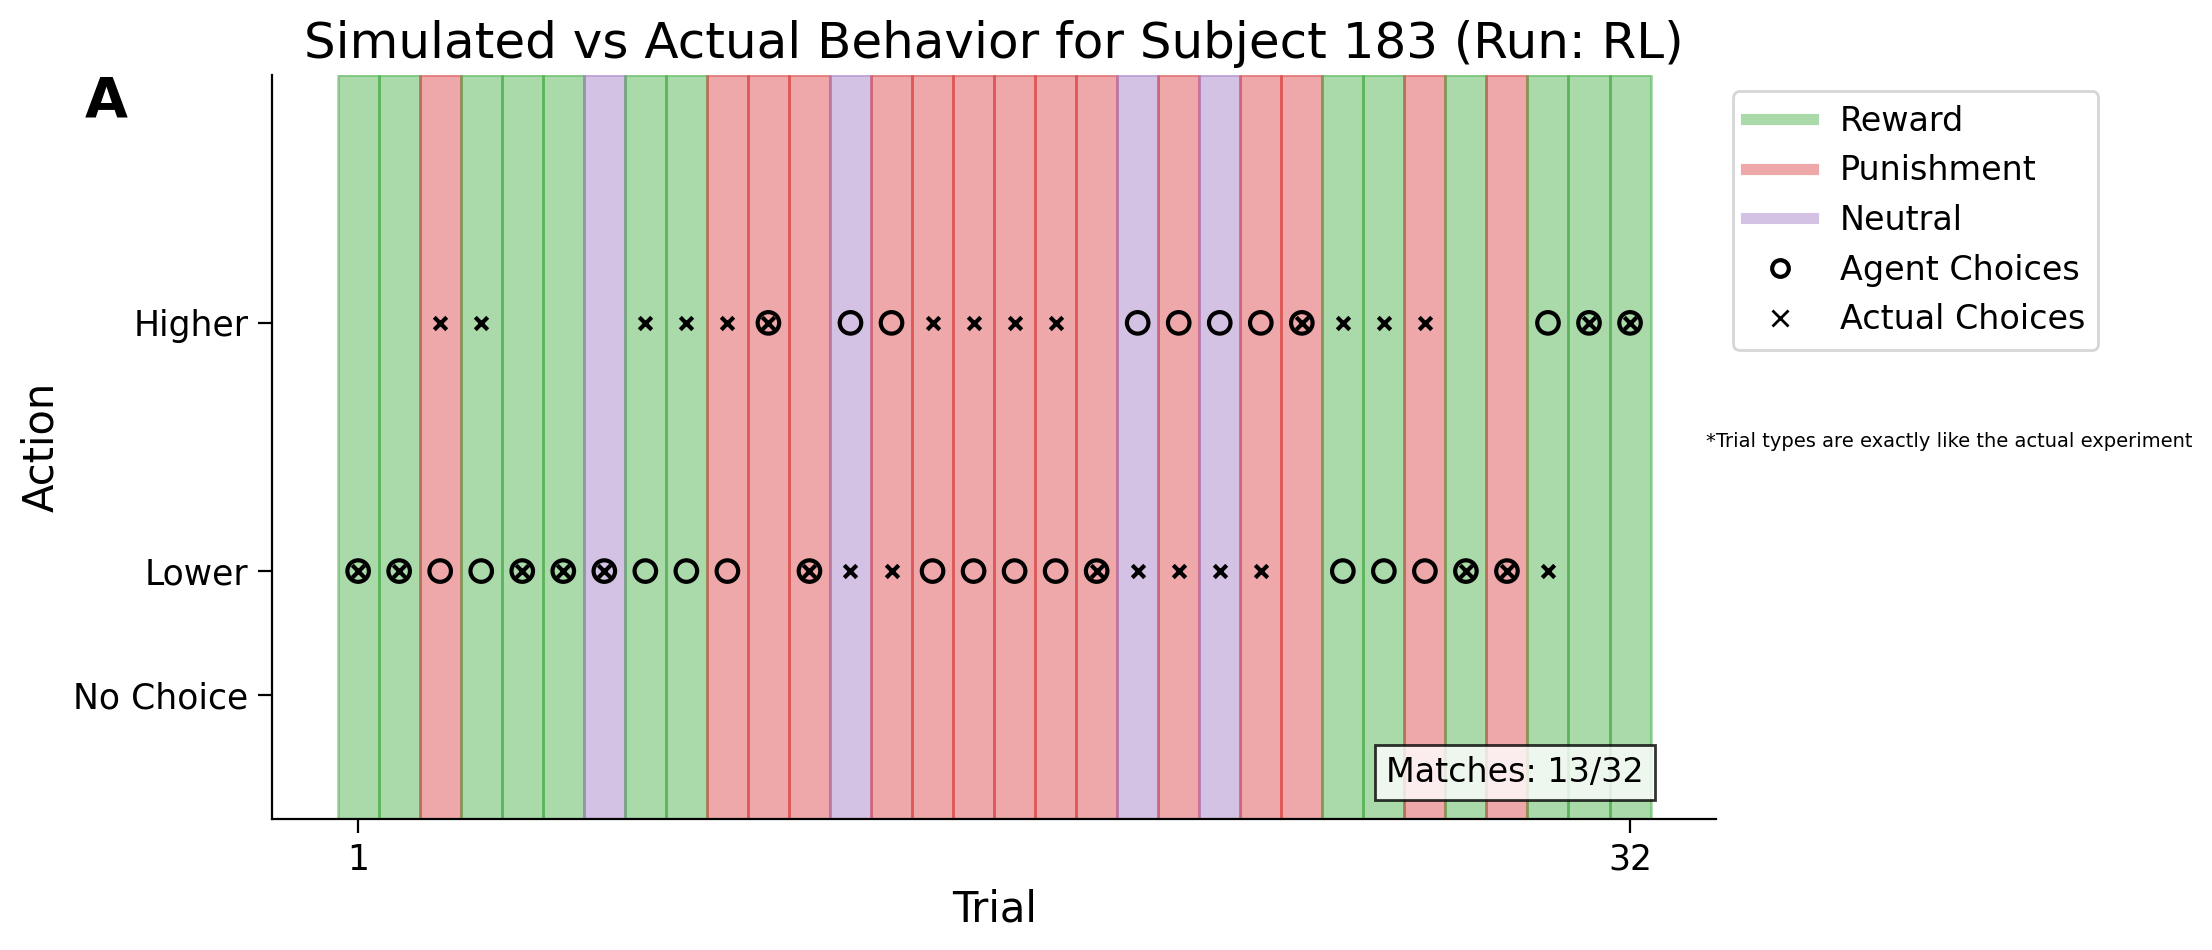

In [17]:
subject = 183
run = "RL"

choices, feedback = load_choice_feedback(subject, run)

# Simulate using the EWA model
alpha, beta, phi = 0.75924706, 6.33214889, 0.60574074
actions, rewards, Qs = sim_subject_ewa(alpha, beta, phi, feedback)

# Calculate the number of matches between simulated actions and actual choices
matches = np.sum(actions == choices)

_, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(choices))

# Use axvspan to show trial types (similar to your original code)
for i in x:
    if rewards[i] == 0:
        ax.axvspan(i - 0.5, i + 0.5, color="C3", alpha=0.4)
    elif rewards[i] == 1:
        ax.axvspan(i - 0.5, i + 0.5, color="C2", alpha=0.4)
    elif rewards[i] == 0.5:
        ax.axvspan(i - 0.5, i + 0.5, color="C4", alpha=0.4)

# Scatter plot for agent choices without color differentiation
ax.scatter(x, actions, edgecolors="black", facecolors="none", s=60, label="Agent Choices", linewidth=1.5, marker='o', zorder=3)

# Plot actual choices, including "No Choice" as -0.5
actual_y = np.where(choices == -1, -0.5, choices)  # Map "No Choice" to -0.5
ax.scatter(x, actual_y, c="black", s=20, label="Actual Choices", marker='x', zorder=4)

# Annotate correlation in the plot
ax.text(0.95, 0.05, f"Matches: {matches}/{len(choices)}", transform=ax.transAxes, ha="right", fontsize=12, bbox=dict(facecolor="white", alpha=0.8))

# Adjust x-axis ticks to show only the first and last trial numbers
ax.set_xticks([0, len(choices) - 1])  # Ticks at the first and last trial indices
ax.set_xticklabels([1, len(choices)])  # Labels corresponding to trial numbers (1-based)

ax.text(1.33, 0.52, "*Trial types are exactly like the actual experiment", fontsize=7, ha="right", va="top", transform=ax.transAxes)

ax.set_yticks([-0.5, 0, 1], ["No Choice", "Lower", "Higher"])
ax.set_ylim(-1, 2)
ax.set_ylabel("Action")
ax.set_xlabel("Trial")

reward_patch = plt.Line2D([0], [0], color="C2", lw=4, alpha=0.4, label="Reward")
punishment_patch = plt.Line2D([0], [0], color="C3", lw=4, alpha=0.4, label="Punishment")
neutral_patch = plt.Line2D([0], [0], color="C4", lw=4, alpha=0.4, label="Neutral")
ax.legend(handles=[reward_patch, punishment_patch, neutral_patch,
                   plt.Line2D([0], [0], color="black", marker='o', linestyle='', markerfacecolor='none', markeredgewidth=1.5, label="Agent Choices"),
                   plt.Line2D([0], [0], color="black", marker='x', linestyle='', label="Actual Choices")],
          bbox_to_anchor=(1, 1), fontsize=12)
plt.text(-0.1, 1, 'A',
         horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

plt.title(f"Simulated vs Actual Behavior for Subject {subject} (Run: {run})")
plt.show()


### Aganet choices vs Actual choices (LR)

In [11]:
subject = 151
run = "LR"

choices, feedback = load_choice_feedback(subject, run)

Mr, Mc = 3, 3  # Number of history terms for rewards and choices

X, y = prepare_history_features(choices, feedback, Mr, Mc)

coefficients = fit_model(X, y, Mr, Mc, lr=0.1, epochs=1000)

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.5734
Epoch 200, Loss: 0.5292
Epoch 300, Loss: 0.5074
Epoch 400, Loss: 0.4953
Epoch 500, Loss: 0.4879
Epoch 600, Loss: 0.4830
Epoch 700, Loss: 0.4797
Epoch 800, Loss: 0.4774
Epoch 900, Loss: 0.4757

Final Coefficients:
Reward Coefficients:
  Coefficient for reward 3 trial(s) ago: 1.6962
  Coefficient for reward 2 trial(s) ago: 1.2539
  Coefficient for reward 1 trial(s) ago: -2.3288

Choice Coefficients:
  Coefficient for choice 3 trial(s) ago: -0.1515
  Coefficient for choice 2 trial(s) ago: -1.4288
  Coefficient for choice 1 trial(s) ago: -0.6364


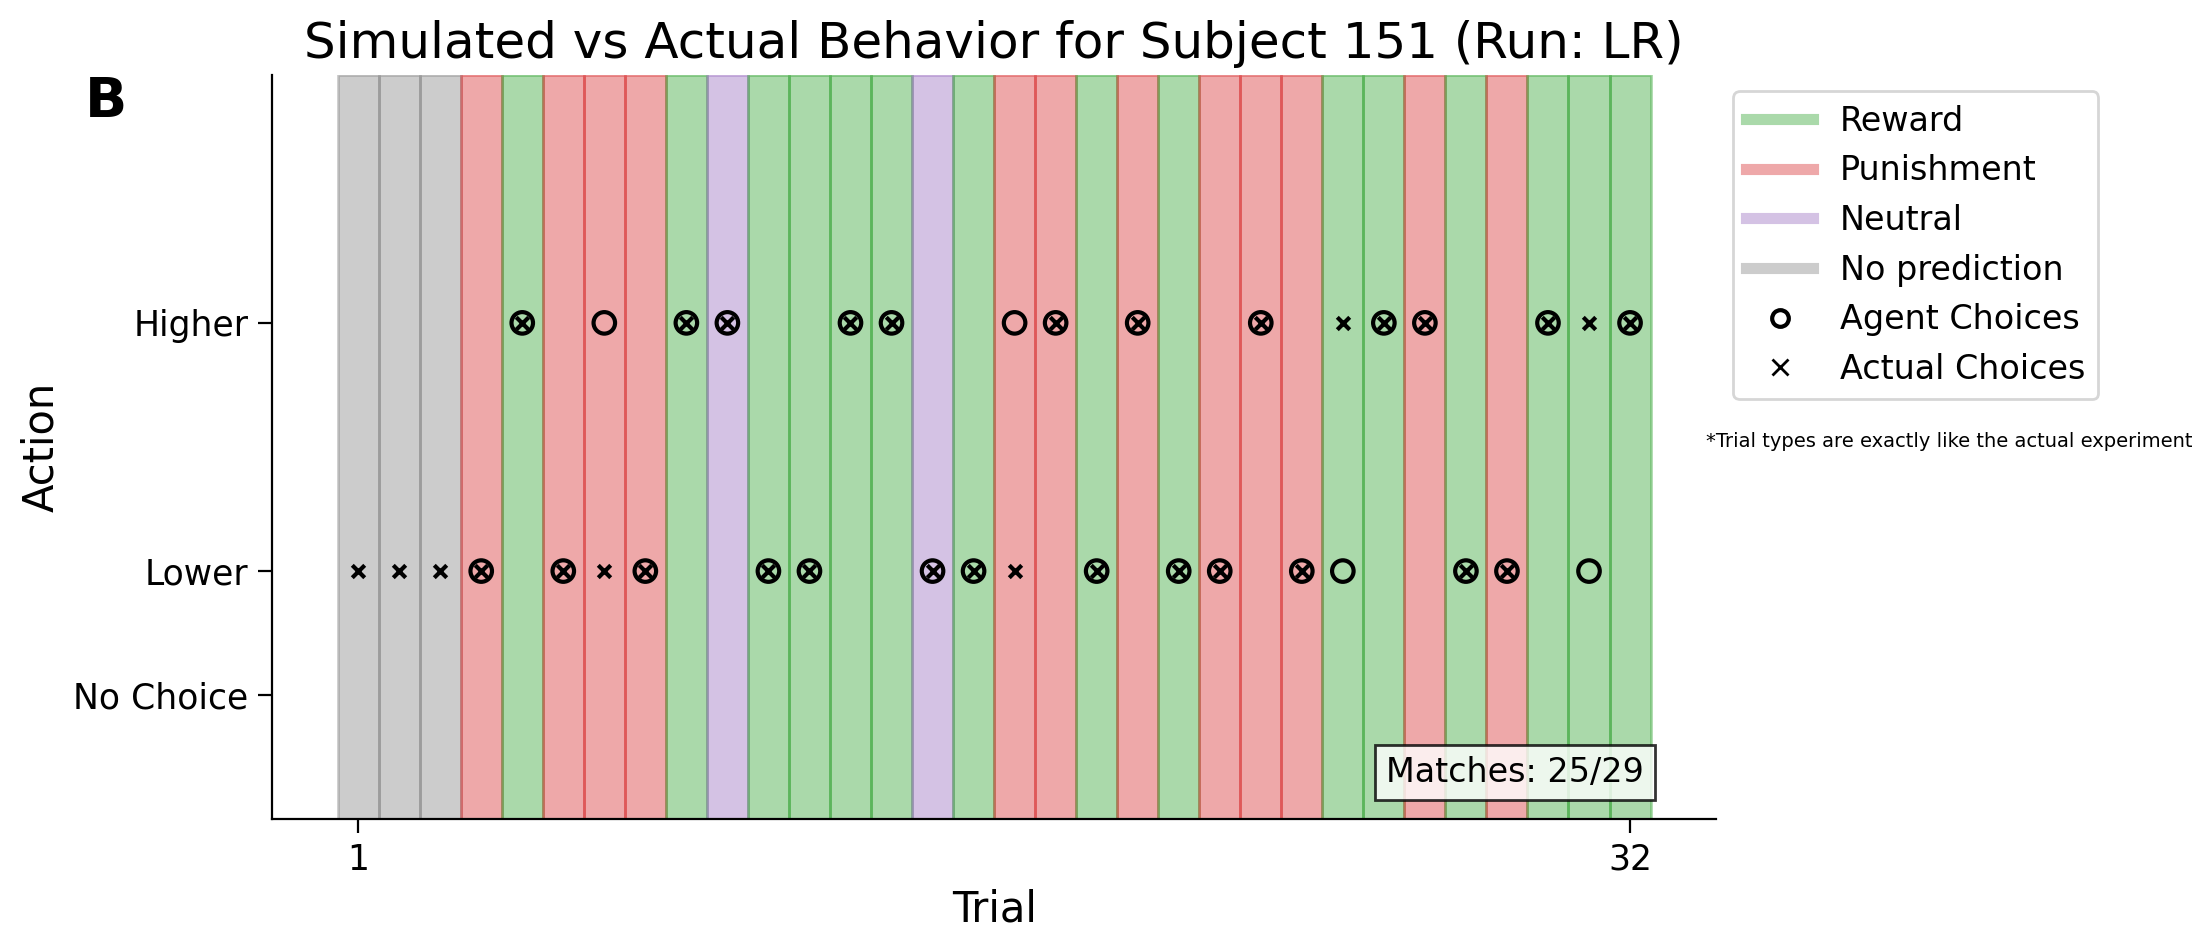

In [ ]:
choices, feedback = load_choice_feedback(subject, run)
actions = sim_subject_lr(coefficients, choices, feedback, Mr, Mc)

# Calculate the number of matches between simulated actions and actual choices
matches = np.sum(actions == choices)

_, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(choices))

# Use axvspan to show trial types
for i in x:
    # Change color for the first three trials
    if i < max(Mr, Mc):
        ax.axvspan(i - 0.5, i + 0.5, color="gray", alpha=0.4)
    else:
        if feedback[i] == 0:
            ax.axvspan(i - 0.5, i + 0.5, color="C3", alpha=0.4)
        elif feedback[i] == 1:
            ax.axvspan(i - 0.5, i + 0.5, color="C2", alpha=0.4)
        elif feedback[i] == 0.5:
            ax.axvspan(i - 0.5, i + 0.5, color="C4", alpha=0.4)

# Scatter plot for agent choices without color differentiation
ax.scatter(x, actions, edgecolors="black", facecolors="none", s=60, label="Agent Choices", linewidth=1.5, marker='o', zorder=3)

# Plot actual choices, including "No Choice" as -0.5
actual_y = np.where(choices == -1, -0.5, choices)  # Map "No Choice" to -0.5
ax.scatter(x, actual_y, c="black", s=20, label="Actual Choices", marker='x', zorder=4)

# Annotate correlation in the plot
ax.text(0.95, 0.05, f"Matches: {matches}/{len(choices)-max(Mr, Mc)}", transform=ax.transAxes, ha="right", fontsize=12, bbox=dict(facecolor="white", alpha=0.8))

# Adjust x-axis ticks to show only the first and last trial numbers
ax.set_xticks([0, len(choices) - 1])  # Ticks at the first and last trial indices
ax.set_xticklabels([1, len(choices)])  # Labels corresponding to trial numbers (1-based)

ax.text(1.33, 0.52, "*Trial types are exactly like the actual experiment", fontsize=7, ha="right", va="top", transform=ax.transAxes)

ax.set_yticks([-0.5, 0, 1], ["No Choice", "Lower", "Higher"])
ax.set_ylim(-1, 2)
ax.set_ylabel("Action")
ax.set_xlabel("Trial")

reward_patch = plt.Line2D([0], [0], color="C2", lw=4, alpha=0.4, label="Reward")
punishment_patch = plt.Line2D([0], [0], color="C3", lw=4, alpha=0.4, label="Punishment")
neutral_patch = plt.Line2D([0], [0], color="C4", lw=4, alpha=0.4, label="Neutral")
gray_patch = plt.Line2D([0], [0], color="gray", lw=4, alpha=0.4, label="No prediction")

ax.legend(handles=[reward_patch, punishment_patch, neutral_patch, gray_patch,
                   plt.Line2D([0], [0], color="black", marker='o', linestyle='', markerfacecolor='none', markeredgewidth=1.5, label="Agent Choices"),
                   plt.Line2D([0], [0], color="black", marker='x', linestyle='', label="Actual Choices")],
          bbox_to_anchor=(1, 1), fontsize=12)
plt.text(-0.1, 1, 'B',
         horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

plt.title(f"Simulated vs Actual Behavior for Subject {subject} (Run: {run})")
plt.show()

### DMN signals

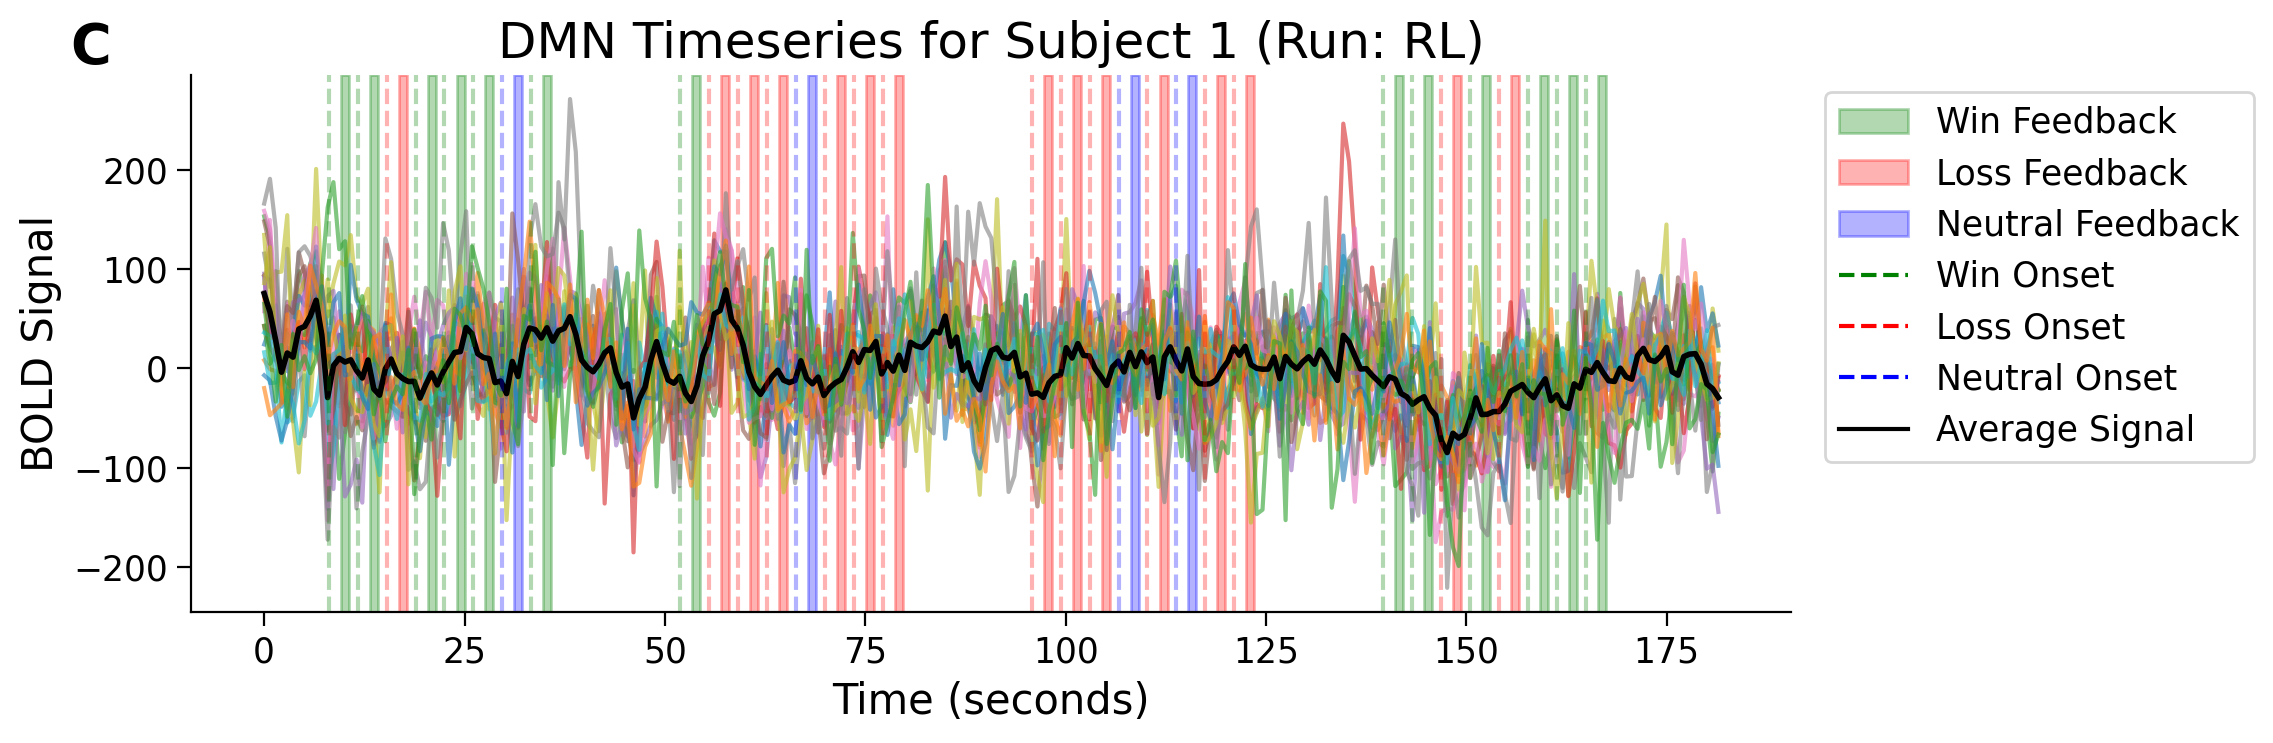

In [ ]:
subject = 1
run = "RL"
if run == "RL":
    run_as_num = 0
elif run == "LR":
    run_as_num = 1
task = "GAMBLING"

timeseries_task = [] # (1 because load_timeseries is wrapped in a list, 2 runs, 360 regions, 253 timepoints)
timeseries_task.append(load_timeseries(subject, task,
                                         dir=os.path.join(HCP_DIR, "hcp_task"),
                                         concat=False))

run_timeseries_task = timeseries_task[0][run_as_num] # RL (The first 0 index is because load_timeseries is wrapped in a list)
dmn_signal = run_timeseries_task[DMN_PARCELS, :]

# Calculate the average time series across DMN parcels
average_dmn = np.mean(dmn_signal, axis=0)

# Load EV files
win_evs = load_evs(subject, task, "win_event", dir=os.path.join(HCP_DIR, "hcp_task"))
loss_evs = load_evs(subject, task, "loss_event", dir=os.path.join(HCP_DIR, "hcp_task"))
neut_evs = load_evs(subject, task, "neut_event", dir=os.path.join(HCP_DIR, "hcp_task"))

# Onset times for the first run (0 or RL)
win_onsets = win_evs[run_as_num]["onset"]  # Onset times for win events
loss_onsets = loss_evs[run_as_num]["onset"]  # Onset times for loss events
neut_onsets = neut_evs[run_as_num]["onset"]  # Onset times for neutral events

plt.figure(figsize=(12, 4))

# Plot time series for each DMN parcel
time_in_seconds = np.arange(dmn_signal.shape[1]) * TR
for idx, parcel_time_series in enumerate(dmn_signal):
    plt.plot(time_in_seconds, parcel_time_series, alpha=0.6)

# Add the average time series to the plot
plt.plot(time_in_seconds, average_dmn, color="black", linewidth=2)

# Add shaded spans for feedback periods with colors based on event type
for onset in win_onsets:
    feedback_start = onset + 1.5  # Feedback starts 1.5s after onset
    feedback_end = feedback_start + 1.0  # Feedback lasts 1s
    plt.axvspan(feedback_start, feedback_end, color="green", alpha=0.3)

for onset in loss_onsets:
    feedback_start = onset + 1.5
    feedback_end = feedback_start + 1.0
    plt.axvspan(feedback_start, feedback_end, color="red", alpha=0.3)

for onset in neut_onsets:
    feedback_start = onset + 1.5
    feedback_end = feedback_start + 1.0
    plt.axvspan(feedback_start, feedback_end, color="blue", alpha=0.3)

for onset in win_onsets:
    plt.axvline(onset, color="green", linestyle="--", alpha=0.3)
for onset in loss_onsets:
    plt.axvline(onset, color="red", linestyle="--", alpha=0.3)
for onset in neut_onsets:
    plt.axvline(onset, color="blue", linestyle="--", alpha=0.3)

legend_elements = [
    mpatches.Patch(color="green", alpha=0.3, label="Win Feedback"),
    mpatches.Patch(color="red", alpha=0.3, label="Loss Feedback"),
    mpatches.Patch(color="blue", alpha=0.3, label="Neutral Feedback"),
    mlines.Line2D([0], [0], color="green", linestyle="--", label="Win Onset"),
    mlines.Line2D([0], [0], color="red", linestyle="--", label="Loss Onset"),
    mlines.Line2D([0], [0], color="blue", linestyle="--", label="Neutral Onset"),
    mlines.Line2D([0], [0], color="Black", linestyle="-", label="Average Signal")
]

plt.text(-0.05, 1.1, 'C',
         horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

plt.xlabel("Time (seconds)")
plt.ylabel("BOLD Signal")
plt.title(f"DMN Timeseries for Subject {subject} (Run: {run})")
plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.3, 1), fontsize="small")
plt.tight_layout()
plt.show()

## **Analysis**

### Correlation between average pre-feedback DMN activities and reaction times

In [ ]:
Mr, Mc = 3, 3
task = "GAMBLING"
results = []

for subject in range(1, N_SUBJECTS):
    for run in ["RL", "LR"]:

        choices, feedback = load_choice_feedback(subject, run)
        try:
            avg_dmn = average_dmn(subject, run, feedback)
            avg_dmn = [x if x is not None else 0 for x in avg_dmn]
            correlations = trial_by_trial_regression(avg_dmn, feedback, choices, Mr, Mc)
        except Exception as e:
            print(subject, run)
            pass
        results.append({
                "Subject": subject,
                "Run": run,
                "Reward Correlation": correlations["RewardCorrelation"][0],
                "Reward p-value": correlations["RewardCorrelation"][1],
                "Choice Correlation": correlations["ChoiceCorrelation"][0],
                "Choice p-value": correlations["ChoiceCorrelation"][1]
            })

In [ ]:
df = pd.read_csv("./results.csv")
significant_rewards = df[df["Reward p-value"] < 0.05]
significant_choices = df[df["Choice p-value"] < 0.05]

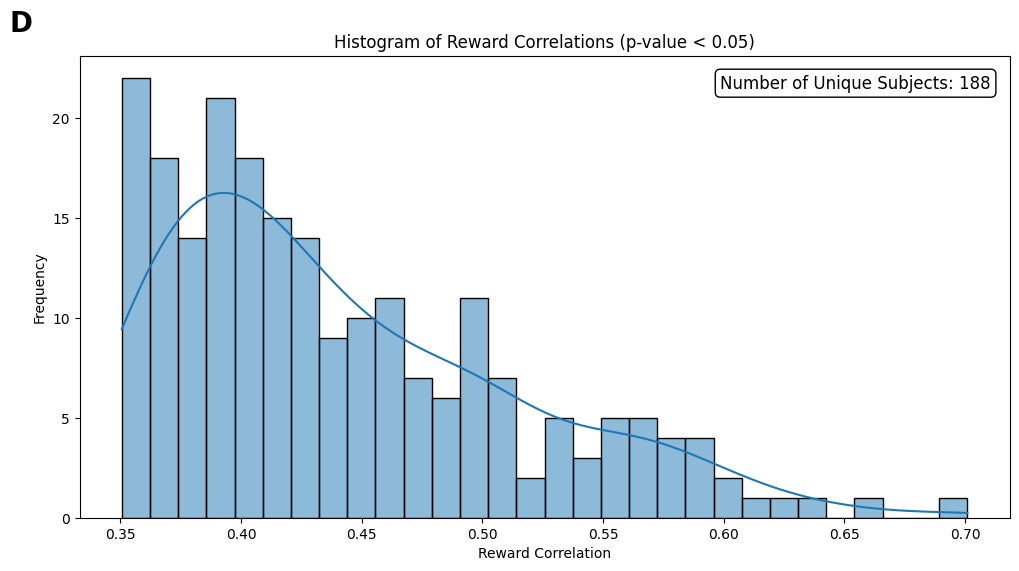

In [ ]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
sns.histplot(significant_rewards["Reward Correlation"], bins=30, kde=True)

unique_subjects = significant_rewards["Subject"].nunique()

plt.text(0.98, 0.96, f'Number of Unique Subjects: {unique_subjects}',
         horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.text(-0.05, 1.1, 'D', horizontalalignment='right',
         verticalalignment='top', transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

plt.title("Histogram of Reward Correlations (p-value < 0.05)")
plt.xlabel("Reward Correlation")
plt.ylabel("Frequency")

plt.show()

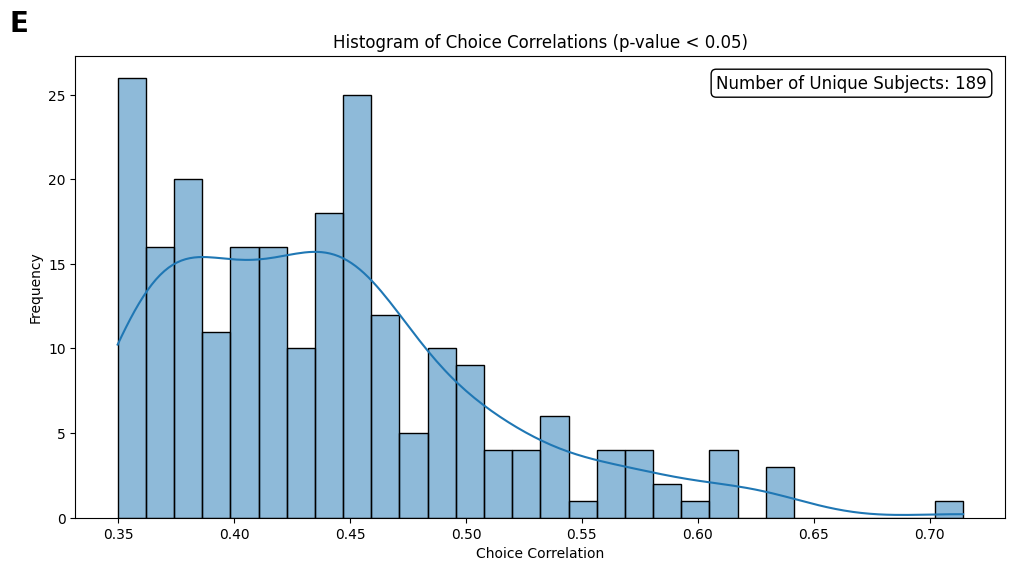

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(significant_choices["Choice Correlation"], bins=30, kde=True)

unique_subjects = significant_choices["Subject"].nunique()

plt.text(0.98, 0.96, f'Number of Unique Subjects: {unique_subjects}',
         horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.text(-0.05, 1.1, 'E', horizontalalignment='right',
         verticalalignment='top', transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

plt.title("Histogram of Choice Correlations (p-value < 0.05)")
plt.xlabel("Choice Correlation")
plt.ylabel("Frequency")

plt.show()